In [1]:
import numpy as np
import pandas as pd
import tqdm
from scipy import signal
from pathlib import Path

from dataset_processor import (
    AddGravityColumn,
    Convert_G_to_Ms2,
    ButterworthFilter,
    Resampler,
    Windowize,
    AddStandardActivityCode,
    RenameColumns,
    SplitGuaranteeingAllClassesPerSplit,
    BalanceToMinimumClass,
    Pipeline
)

In [2]:
def read_uci(uci_path):
    """Le o dataset do motionsense e retorna um dataframe com os dados (vindos de todos os arquivos CSV)
    O dataframe retornado possui as seguintes colunas:
    - attitude.roll: Rotação em torno do eixo x
    - attitude.pitch: Rotação em torno do eixo y
    - attitude.yaw: Rotação em torno do eixo z
    - gravity.x: Gravidade em torno do eixo x
    - gravity.y: Gravidade em torno do eixo y
    - gravity.z: Gravidade em torno do eixo z
    - rotationRate.x: Velocidade angular em torno do eixo x
    - rotationRate.y: Velocidade angular em torno do eixo y
    - rotationRate.z: Velocidade angular em torno do eixo z
    - userAcceleration.x: Aceleração no eixo x
    - userAcceleration.y: Aceleração no eixo y
    - userAcceleration.z: Aceleração no eixo z
    - activity code: Código da atividade
    - index: Índice da amostra vindo do txt
    - user: Usuário que realizou a atividade
    - serial: Número de série da atividade
    - txt: Caminho do txt que contém a atividade

    Parameters
    ----------
    uci_path : str
        Caminho para o dataset MotionSense

    Returns
    -------
    pd.DataFrame
        Dataframe com os dados do dataset UCI-HAR
    """
    activity_names = {
        1: "WALKING", 
        2: "WALKING_UPSTAIRS", 
        3: "WALKING_DOWNSTAIRS", 
        4: "SITTING", 
        5: "STANDING", 
        6: "LAYING",
        7: "STAND_TO_SIT",
        8: "SIT_TO_STAND",
        9: "SIT_TO_LIE",
        10: "LIE_TO_SIT",
        11: "STAND_TO_LIE",
        12: "LIE_TO_STAND"
    }
    activity_codes = {v: k for k, v in activity_names.items()}
    
    feature_columns = [
        "accel-x",
        "accel-y",
        "accel-z",
        "gyro-x",
        "gyro-y",
        "gyro-z",
    ]
    
#     df_labels = pd.read_csv("data/RawData/labels.txt", header=None, sep=" ")
    df_labels = pd.read_csv(uci_path / "labels.txt", header=None, sep=" ")
    df_labels.columns=["serial", "user", "activity code", "start", "end"]
    
    uci_path = Path(uci_path)
    
    dfs = []
    data_path = list(uci_path.glob("*.txt"))
    new_data_path = [elem.name.split("_")+[elem] for elem in sorted(data_path)]
    df = pd.DataFrame(new_data_path, columns=["sensor", "serial", "user", "file"])
    for key, df2 in df.groupby(["serial", "user"]):
        acc, gyr = None, None
        for row_index, row in df2.iterrows():
            data = pd.read_csv(row["file"], header=None, sep=" ")
            if row["sensor"] == "acc":
                acc = data
            else:
                gyr = data
        new_df = pd.concat([acc, gyr], axis=1)
        new_df.columns = feature_columns
        
        user = int(key[1].split(".")[0][4:])
        serial = int(key[0][3:])
        
        new_df['txt'] = row["file"]
        
        new_df["user"] = user
        new_df["serial"] = serial
#         new_df["activity code"] = -1
        
        for row_index, row in df_labels.loc[(df_labels["serial"] == serial) & (df_labels["user"] == user)].iterrows():
            start = row['start']
            end = row["end"]+1
            activity = row["activity code"]
            resumed_df = new_df.loc[start:end].copy()
            resumed_df["index"] = [i for i in range(start, end+1)]
            resumed_df["activity code"] = activity
            
            dfs.append(resumed_df)
    
    df = pd.concat(dfs)
    df.reset_index(inplace=True, drop=True)
    return df

In [3]:
# Caminho para o dataset UCI-HAR
uci_path = Path("data/raw/UCI/RawData/")
# Caminho para salvar o dataset pré-processado
output_path = Path("data/processed/UCI")
# Cria o caminho de saída se ele não existir
output_path.mkdir(parents=True, exist_ok=True)

# Lista com as colunas que são features
feature_columns = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z",
]

# Nome das colunas que serão usada para agrupar as janelas
column_group = ["user", "activity code", "serial"]

# activity code: standard activity code
standard_activity_code_map = {
    1: 2, # walk
    2: 3, # stair up
    3: 4, # stair down
    4: 0, # sit
    5: 1, # stand
    6: -1, # Laying
    7: -1, # stand to sit
    8: -1, # sit to stand
    9: -1, # sit to lie
    10: -1, # lie to sit
    11: -1, # stand to lie
    12: -1 # lie to stand
}

## Bruto

## Normatizado

In [4]:
from dataset_processor import (
    AddGravityColumn,
    Convert_G_to_Ms2,
    ButterworthFilter,
    Resampler,
    Windowize,
    AddStandardActivityCode,
    RenameColumns,
    SplitGuaranteeingAllClassesPerSplit,
    BalanceToMinimumClass,
    Pipeline
)

# Lê o dataset
dataframe = read_uci(uci_path)

# Instancia o objeto que converte a aceleração para m/s²
conversor = Convert_G_to_Ms2(
    axis_columns=["accel-x", "accel-y", "accel-z"],             # Nome das colunas do aceletômetro que serão convertidas
)

# Instancia o objeto que aplica o filtro Butterworth
butterworth = ButterworthFilter(
    axis_columns=["accel-x", "accel-y", "accel-z"],             # Nome das colunas do aceletômetro em que o filtro será aplicado
    fs=50                                                       # Frequência de amostragem original
)

# Instacia o objeto que reamostra os dados para 20Hz (supondo que o dataset original é 50Hz, constante)
resampler = Resampler(
    features_to_select=feature_columns,                         # Nome das colunas que serão usadas como features
    original_fs=50,                                             # Frequência de amostragem original
    target_fs=20,                                               # Frequência de amostragem desejada
    groupby_column=column_group,                                # Agrupa pela coluna do txt. A reamostragem é feita para cada grupo da coluna txt
)

# Instancia o objeto que cria as janelas
windowizer = Windowize(
    features_to_select=feature_columns,                         # Nome das colunas que serão usadas como features
    samples_per_window=20,                                      # Numero de amostras por janela 
    samples_per_overlap=0,                                      # Numero de amostras que se sobrepõem
    groupby_column=column_group,                                # Agrupa pela coluna do txt. As janelas são criadas para cada grupo da coluna CSV
)

# Instancia o objeto que adiciona a coluna com o código da atividade
standard_label_adder = AddStandardActivityCode(standard_activity_code_map)

# Cria o pipeline
# 1. Converte a aceleração para m/s²
# 2. Aplica o filtro Butterworth
# 3. Reamostra os dados para 20Hz
# 4. Cria as janelas
# 5. Adiciona a coluna com o código da atividade
pipeline = Pipeline(
    [
        # conversor,
        # butterworth,
        resampler,
        # windowizer,
        standard_label_adder
    ]
)

# Executa o pipeline
new_df_normalized = pipeline(dataframe)
# # Salva os dados
# new_df_normalized.to_csv(output_path / "standartized_unbalanced.csv", index=False)
# new_df_normalized

Executing Resampler


Resampling: 100%|██████████| 714/714 [00:02<00:00, 294.76it/s]


Executing AddStandardActivityCode


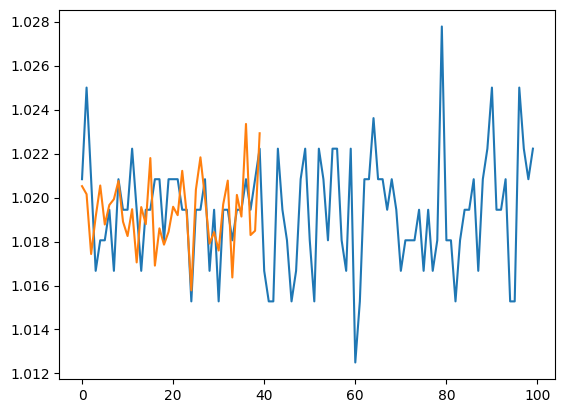

In [16]:
import matplotlib.pyplot as plt
import plotly.express as px


sample = np.array(dataframe['accel-x'])
sample2 = np.array(new_df_normalized['accel-x'])



plt.plot(sample[:100])
plt.plot(sample2[:40])

In [7]:
sample[:1], sample2[:1]

(array([1.02083339]), array([1.02051774]))